# Determination of relative  point coordinates in the system by the distance between them

<b>Contents:</b>

[1 Агоритм решения](#section_1)

[2  Краткое описание подводных камней на пути к достижению цели](#section_2)

[3  Процесс обучения](#section_3)

[4  Определение координат системы точек](#section_4)

[5  Заключение](#section_5)

Постановка задачи: на некоторой плоскости находится N точек (датчиков).

Известны расстояния между ними, пусть пока для определенности - все расстояния.
Задание: установить относительные координаты точек в системе

In [16]:
import pandas as pd
import numpy as np
from PIL import Image
from IPython.display import display

In [17]:
data=pd.read_csv('Dataframe.csv')
data

,D1,D2,Distance
0,id_0,id_1,0.699213
1,id_0,id_2,0.770766
2,id_0,id_3,0.697799
3,id_0,id_4,0.780878
4,id_1,id_2,0.014621
5,id_1,id_3,0.814849
6,id_1,id_4,0.460873
7,id_2,id_3,1.038910
8,id_2,id_4,0.639418
9,id_3,id_4,0.082570


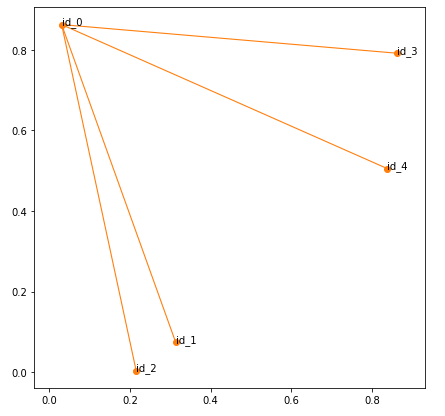

In [18]:
im=Image.open('pic1.PNG')
display(im)

Так вот это все примерно выглядит для 5 точек, например.

Задачу, вероятно, можно решить аналитически, я же использую модель машинного обучения для определения координат на основе нейросети.

<a id='section_1'></a>
# Агоритм решения

Обучение нейросети генерировать координаты по подаваемой последовательности длин - расстояний между точками

Примерно, процесс обучения выглядит так: подаю в качестве input на обучение последовательность вида [s1,s2,s3..sn], получаю последовательность точек [0.,0., x1,y1,x2,y2 ... xn,yn]

<a id='section_2'></a>
# Краткое описание подводных камней на пути к достижению цели

1. Привязка к базису при генерировании координат точек
2. Ограничение подаваемой последовательности до трех (для трех точек)
3. Избавление от квадратного корня
4. И еще, но позже

## Теперь по порядку

### Привязка к базису при генерировании координат точек

Если взять за начало отсчета точку О, например, с координатами [0,0] и больше ни к чему не привязываться, то модели не понятно в каком направлении генерировать координаты, ибо будет бесконечное число степеней свободы. Формально такая генерация выглядит так:

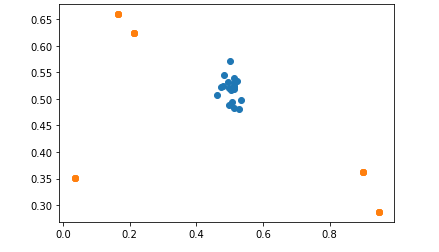

In [19]:
im=Image.open('pic2.PNG')
display(im)

Здесь оранжевым цветом показаны первичные точки, а синим сгенерировыанные.

Поэтому первым этапом необходимо определить вторую точку, тогда модель начинает обучаться в нужном напрвлении. Я такую точку выбрал на оси Y, то есть первая сторона многоугольника всегда ориентирована вдоль оси OY

### Ограничение подаваемой последовательности до трех (для трех точек)

Даже при привязке к двум точкам, все равно сохраняется неопределенность, при определении координат по расстояниям. Как видно на рисунке, модель не видит разницы между положением точки 2 и 2'.

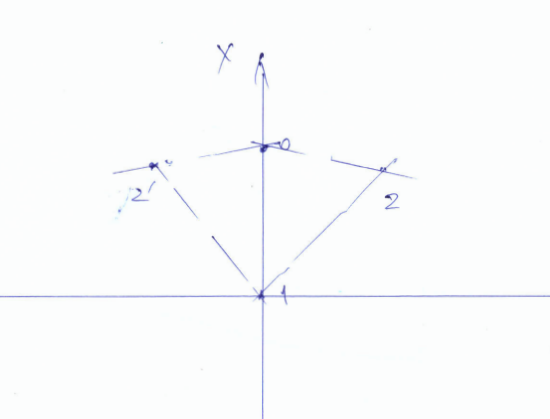

In [20]:
im=Image.open('pic3.PNG')
display(im)

А если точек будет больше 3 то модель вообще никогда не сойдется. Поэтому, ограничиваю модель тремя точками и расположением по умолчанию в первой четверти координат.

Остальные точки буду находить, подавая по очереди расстояния до них в модель.

### Избавление от квадратного корня

Следующий ход - избавление корня квадратного при вычислении расстояния между двумя точками из известного уравнения 

То есть я буду подавать на вход не расстояние, а его квадрат. Что несколько ускоряет обучение.

<a id='section_3'></a>
# Процесс обучения

## Генерация данных для обучения

Сначала надо придумать данные на которых будем обучать модель

In [222]:
import random as rd
from numpy import cumsum
from random import random
from numpy import array
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.models import load_model
import keras.backend as K
from matplotlib import pyplot as plt
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
import pandas as pd
import numpy as np
from matplotlib import collections  as mcol
from random import sample
import operator

In [127]:
# Функция генерирования данных, в зависимости от количества точек
def generate_data(points):
    data=np.random.random_sample((points, 2))
    data[0][0]=0
    data[0][1]=0
    data[1][0]=0
    lst=[]
    for j in range(data.shape[0]):
        for i in range(j+1,data.shape[0]):
            res=(data[j], data[i])
            lst.append(res)
    data=lst
    return data

In [31]:
points=3
data=generate_data(points)
pd.DataFrame(data)

,0,1
0,"[0.0, 0.0]","[0.0, 0.9894635]"
1,"[0.0, 0.0]","[0.1358287, 0.0481572]"
2,"[0.0, 0.9894635]","[0.1358287, 0.0481572]"


In [28]:
# Генерация последовательностей X и y
def generate_seq(points):
    df=generate_data(points)
    arr_x=[np.sqrt((df[i][0][0]-df[i][1][0])**2+
                       (df[i][0][1]-df[i][1][1])**2) for i in range(len(df))]
    arr_y=[]
    for i1 in range(len(df)):
        for i2 in range(2):
            for i3 in range(2):
                arr_y.append(df[i1][i2][i3])
    X=arr_x
    y=arr_y
    return X, y

In [32]:
X,y=generate_seq(points)

In [36]:
# Это последовательтность, расстояний между точками, 
# которую буду подавать на вход
X

[0.9371476, 1.100991947173475, 0.5581551683016113]

In [37]:
# А это координаты точек, которые будут целью обучения - выход
y

[0.0,
 0.0,
 0.0,
 0.9371476,
 0.0,
 0.0,
 0.5580272,
 0.949099,
 0.0,
 0.9371476,
 0.5580272,
 0.949099]

In [ ]:
# функция выхода в последовательность для визуализации данных
def y_to_seq(y):
    lst=[]
    i=0
    for x in range(int(len(y)/4)):
        lst.append([(y[i],y[i+1]),(y[i+2],y[i+3])])
        i=i+4
    return lst

In [38]:
# функция визуализации двух треугольников для сравнения
def plot_lines_2_plots(seq1, seq2):
    c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
    lc1 = mcol.LineCollection(points1, colors=c, linewidths=1.1)
    lc2 = mcol.LineCollection(points2, colors=c,linewidths=1.1)
    fig, ax = plt.subplots()
    ax.add_collection(lc1)
    ax.add_collection(lc2)
    ax.autoscale()
    ax.margins(0.1)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axis('equal')

In [39]:
# генерация набора последовательностей
def generate_samples(n_examples, points):
    X, y = list(), list()
    for _ in range(n_examples):
        in_pattern, out_pattern = generate_seq(points)
        X.append(in_pattern)
        y.append(out_pattern)
    X=np.array(X)
    X=X.reshape(n_examples,1,x_length)
    y=np.array(y)
    y=y.reshape(n_examples,1,y_length)    
    return X, y


In [128]:
# Собираю все в кучу
import random as rd
from numpy import cumsum
from random import random
from numpy import array
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.models import load_model
import keras.backend as K
from matplotlib import pyplot as plt
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
import pandas as pd
import numpy as np
from matplotlib import collections  as mcol

# Функция генерирования данных, в зависимости от количества точек
def generate_data(points):
    data=np.random.random_sample((points, 2))
    data[0][0]=0
    data[0][1]=0
    data[1][0]=0
    lst=[]
    for j in range(data.shape[0]):
        for i in range(j+1,data.shape[0]):
            res=(data[j], data[i])
            lst.append(res)
    data=lst
    return data

# Генерация последовательностей X и y
def generate_seq(points):
    df=generate_data(points)
    arr_x=[np.sqrt((df[i][0][0]-df[i][1][0])**2+
                       (df[i][0][1]-df[i][1][1])**2) for i in range(len(df))]
    arr_y=[]
    for i1 in range(len(df)):
        for i2 in range(2):
            for i3 in range(2):
                arr_y.append(df[i1][i2][i3])
    X=arr_x
    y=arr_y
    return X, y

# функция выхода в последовательность для визуализации данных
def y_to_seq(y):
    lst=[]
    i=0
    for x in range(int(len(y)/4)):
        lst.append([(y[i],y[i+1]),(y[i+2],y[i+3])])
        i=i+4
    return lst

# функция визуализации двух треугольников для сравнения
def plot_lines_2_plots(seq1, seq2):
    c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
    lc1 = mcol.LineCollection(seq1, colors=c, linewidths=1.1)
    lc2 = mcol.LineCollection(seq2, colors=c,linewidths=1.1)
    fig, ax = plt.subplots()
    ax.add_collection(lc1)
    ax.add_collection(lc2)
    ax.autoscale()
    ax.margins(0.1)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axis('equal')
    
# генерация набора последовательностей
def generate_samples(n_examples, points):
    X, y = list(), list()
    for _ in range(n_examples):
        in_pattern, out_pattern = generate_seq(points)
        X.append(in_pattern)
        y.append(out_pattern)
    X=np.array(X)
    X=X.reshape(n_examples,1,x_length)
    y=np.array(y)
    y=y.reshape(n_examples,1,y_length)    
    return X, y



## Определяю модель

In [203]:
points=3
# длина последовательности x
x_length=cumsum(range(points))[-1]
# длина послеловательности y
y_length=x_length*4

# Определяю модель
model = Sequential()
model.add(Bidirectional(LSTM(200, return_sequences=True), input_shape=(1, 3)))
model.add(Bidirectional(LSTM(200, return_sequences=True)))
model.add(Bidirectional(LSTM(200, return_sequences=True)))
model.add(TimeDistributed(Dense(y_length, activation='relu')))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 1, 400)            326400    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 1, 400)            961600    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 1, 400)            961600    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 12)             4812      
Total params: 2,254,412
Trainable params: 2,254,412
Non-trainable params: 0
_________________________________________________________________


Опытным путем подобрал вид LSTM, количество слоев и нейронов. Bidirectional - это значит что один слой делится на два, в котором в одном - данные проходят в одном направлении, а в другом в обратном. И в конце соединяются в одну последовательность, путем соединения, умножения, сложения и тд. По умолчанию стоит соединение в одну последовательность, что вполне подходит, ибо у меня входная последовательность короче выходной

Вход input длиной 3 - количество сторон в треугольнике. Выход:

In [43]:
y_length

12

12 - количество выходных координат

Активация для выходного слоя 'relu' - помогающая бороться с исчезающими градиентами

Функция потерь - среднее абсолютное отклонение 'mae'.
Оптимизация 'adam'

Все эти характеристики были установлены опытным путем, как наиболее оптимальные для скорости и качества обучения.

Пробовал обучаться еще кастомной евклидовой функцией потерь, но результат получился хуже.

In [45]:
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1)) 

## Обучаю модель

In [ ]:
# сюда буду аккумулировать данные с каждой итерации
acc_list=[]
for i in range(5000):
    # генерирую обучающие наборы
    X, y = generate_samples(75000,points)
    # генерирую тестовые наборы
    testX,testy=generate_samples(25000,points)
    history = model.fit(X, y, validation_data=(testX, testy), epochs=1, shuffle=True, batch_size=32,verbose=1)
    # После каждой итерации сохраняю модель на диск
    model.save('model.h5')
    acc_list.append(history.history['val_loss'][0])
    print(sum(acc_list) / len(acc_list))


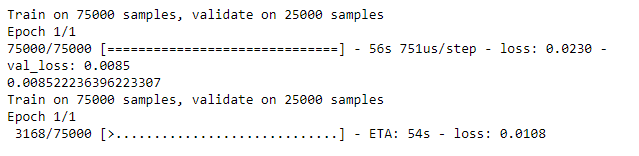

In [47]:
im=Image.open('pic4.PNG')
display(im)

Как видно модель довольно быстро обучается и достигает точности меньше 0.01 за время около минуты. И сохраняет модель на диск.

Такой подход позволяет при достижении необходимой точности в ручную прекратить обучение или временно его остановить, а потом загрузить уже предобученую модель и продолжить обучение, если необходимо.

## Тестирую обученную модель

In [205]:
saved_model = load_model('model.h5')

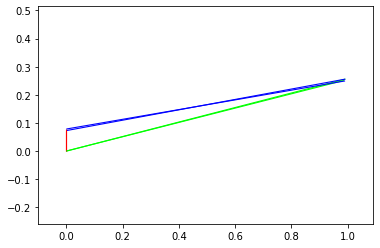

In [206]:
points=3
X, y = generate_samples(1, points)
yhat = saved_model.predict(X, verbose=0)
# генерирую два треугольника: реальный и предсказанный
rect=y_to_seq(y[0][0])
rect2=y_to_seq(yhat[0][0])
plot_lines_2_plots(rect, rect2)

Рисунок сверху показывает, что треугольники реальный и предсказанный совпадают. Выделенные цветом линии облегчают контроль порядка подаваемой последовательности, что потом пригодится для прогнозирования координат всей системы. То что эти два треугольника разные, можно убедится на нижних рисунках. где они разъединены.

In [207]:
def plot_lines(points):
    lc = mcol.LineCollection(points, linewidths=1.1)
    fig, ax = plt.subplots()
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.xlim(-0.2, 1)
    plt.ylim(-0.1, 1)

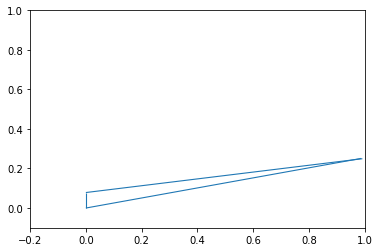

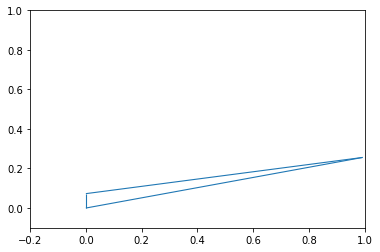

In [208]:
points=3

# длина последовательности x
x_length=cumsum(range(points))[-1]
# длина послеловательности y
y_length=x_length*4

plot_lines(rect2)
plot_lines(rect)
plt.show()

<a id='section_4'></a>
# Определение координат системы точек

Следующий шаг - создание модели для определения относительных координат

Вспомогательные программы:

In [175]:
# генерация точек для датасета
def generate_points(points):
    data=np.round(np.random.random_sample((points, 2)),7)
    index=['id_'+str(i) for i in range(points)]
    data=pd.DataFrame(data, index=index, columns=['X', 'Y'])
    return data

In [176]:
points=6
generate_points(points)

,X,Y
id_0,0.571756,0.114585
id_1,0.325192,0.634229
id_2,0.449632,0.056066
id_3,0.212181,0.505907
id_4,0.571739,0.193784
id_5,0.120611,0.469981


In [177]:
# генерация координат точек
def generate_polygon_coordinates(data):
    data=np.array(data)
    lst=[]
    d_start=[]
    d_end=[]
    for j in range(data.shape[0]):
        for i in range(j+1,data.shape[0]):
            res=(data[j], data[i])
            lst.append(res)
            d_start.append('id_'+str(j))
            d_end.append('id_'+str(i))
    dataframe=lst
    return dataframe, d_start, d_end

# расчет расстояний между точками из созданного датасета
def calculate_distance(data, base_1, base_2):
    id_1='id_'+str(base_1)
    id_2='id_'+str(base_2)
    criteria_1=(data[:,0]==id_1)|(data[:,1]==id_1)
    criteria_2=(data[:,1]==id_2)| (data[:,0]==id_2)
    criteria=criteria_1 & criteria_2
    distance=data[criteria]
    return distance[0][2]

# генерирую данные датафрейма
def generate_dataframe_data(data):
    df, d_start,d_end=generate_polygon_coordinates(data)
    arr_x=[((df[i][0][0]-df[i][1][0])**2+
                       (df[i][0][1]-df[i][1][1])**2) for i in range(len(df))]
    arr_y=[]
    for i1 in range(len(df)):
        for i2 in range(2):
            for i3 in range(2):
                arr_y.append(df[i1][i2][i3])
    X=arr_x
    y=arr_y
    return X, y, df, d_start,d_end

# генерирую датафрейм
def generate_dataframe(data):
    X,y, df, d_start,d_end=generate_dataframe_data(data)
    df=pd.DataFrame(df, columns=['Point_1', 'Point_2'])
    df=df.assign(D1=d_start)
    df=df.assign(D2=d_end)
    df=df.assign(Distance=X)
    return df,y


## Алгоритм решения

Исходные данные, как и прежде имею следующий вид:
    

In [178]:
data=pd.read_csv('Dataframe.csv')
data

,D1,D2,Distance
0,id_0,id_1,0.699213
1,id_0,id_2,0.770766
2,id_0,id_3,0.697799
3,id_0,id_4,0.780878
4,id_1,id_2,0.014621
5,id_1,id_3,0.814849
6,id_1,id_4,0.460873
7,id_2,id_3,1.038910
8,id_2,id_4,0.639418
9,id_3,id_4,0.082570


В таком виде данные и будут подаваться в исходную функцию.

Далее, определяются две базовые точки из датасета, относительно которых и будут расчитываться обученной моделью остальные координаты.

Для этого следующим ходом фиксируется обязательная третья точка: так как модель генерирует треугольники только в первой четверти координат, а любая точка относительно первых двух базовых может находится как слева так и справа, то третья точка служит для определения этого положения сравнивая расстояния

In [179]:
# Функциия сравнивавания расстояния
def closest(lst, K): 
      return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))] 
    
# функция определения координат из двух вариантов: слева и справа от базовой линии      
def compare_euclid_dist(c_1,c_2, distance_3n, coordinates_3):
    variant=[c_1,c_2]
    res1=((c_1[0]-coordinates_3[0])**2+(c_1[1]-coordinates_3[1])**2)
    res2=((c_2[0]-coordinates_3[0])**2+(c_2[1]-coordinates_3[1])**2)
    lst=[res1, res2]
    i=lst.index(closest(lst, distance_3n))
    res=variant[i]
    return res

In [231]:
def calculate_coordinates(data):
    dataframe, _=generate_dataframe(data)
    # нахождение базовых точек
    base_1=int(dataframe[dataframe.Distance==max(dataframe.Distance)].D1.item()[-1])
    base_2=int(dataframe[dataframe.Distance==max(dataframe.Distance)].D2.item()[-1])
    dataset=np.array(dataframe)[:,-3:]
    distances_list=[]
    poly_list=[]
    distance_dict=dict()
    data=data.assign(xhat=0.)
    data=data.assign(yhat=0.)
    # определяю количество точек в многоугольнике для последующей
    # итерации
    num_of_points=data.shape[0]
    points_list=[x for x in range(num_of_points)]
    points_list.remove(base_1)
    points_list.remove(base_2)
    # нахождение 3 точки по максимальным расстояниям до базовых
    for point in points_list:
        id_n='id_'+str(point)
        distance_1n=calculate_distance(dataset, base_1, point)
        distance_2n=calculate_distance(dataset, base_2, point)
        distance_dict[id_n]=distance_1n+distance_2n
    base_3=int(max(distance_dict.items(), key=operator.itemgetter(1))[0][3:])
    points_list.remove(base_3)
    distance_base=calculate_distance(dataset, base_1, base_2)
    distance_13=calculate_distance(dataset, base_1, base_3)
    distance_23=calculate_distance(dataset, base_2, base_3)
    res=saved_model.predict(np.array([[[distance_base, 
                distance_13, distance_23]]]), verbose=0)
    id_1='id_'+str(base_1)
    id_2='id_'+str(base_2)
    id_3='id_'+str(base_3)
    data.loc[id_1, 'xhat']=0.
    data.loc[id_1, 'yhat']=0
    data.loc[id_2, 'xhat']=np.mean([res[0][0][2],res[0][0][8]])
    data.loc[id_2, 'yhat']=np.mean([res[0][0][3],res[0][0][9]])
    data.loc[id_3, 'xhat']=np.mean([res[0][0][6],res[0][0][10]])
    data.loc[id_3, 'yhat']=np.mean([res[0][0][7],res[0][0][11]])
    for point_n in points_list:
        id_n='id_'+str(point_n)
        distance_1n=calculate_distance(dataset, base_1, point_n)
        distance_2n=calculate_distance(dataset, base_2, point_n)
        distance_3n=calculate_distance(dataset, base_3, point_n)
        res=saved_model.predict(np.array([[[distance_base, 
                distance_1n, distance_2n]]]), verbose=0)
        c_1=[np.mean([res[0][0][6],res[0][0][10]]),
                       np.mean([res[0][0][7],res[0][0][11]])]
        c_2=[-np.mean([res[0][0][6],res[0][0][10]]),
                       np.mean([res[0][0][7],res[0][0][11]])]
        coordinates_3=[data.loc[id_3, 'xhat'],data.loc[id_3, 'yhat']]
        res=compare_euclid_dist(c_1,c_2, distance_3n, coordinates_3)
        data.loc[id_n, 'xhat']=res[0]
        data.loc[id_n, 'yhat']=res[1]
    return data

In [232]:
# вспомогательная функция для отображения графиков точек
def lines(data):
    lst_original=[]
    lst_predicted=[]
    lst=data.index.to_list()
    for id_x in lst:
        original=[(data.loc['id_0', 'X'], data.loc['id_0', 'Y']),
                 (data.loc[id_x, 'X'], data.loc[id_x, 'Y'])]
        predicted=[(data.loc['id_0', 'xhat'], data.loc['id_0', 'yhat']),
                 (data.loc[id_x, 'xhat'], data.loc[id_x, 'yhat'])]
        lst_original.append(original)
        lst_predicted.append(predicted)
    return lst_original,lst_predicted

# задаю функцию построения графика
def points_plot(data):
    labels_list=data.index.to_list()
    fig= plt.figure(figsize=(7,7))
    ax=fig.add_subplot(1,1,1)
    ax.scatter(data['X'], data['Y'],c='#ff7f0e', label='Первичные координаты')
    ax.scatter(data['xhat'], data['yhat'],c='#2ca02c', label='Предсказанные координаты')
    for i, txt in enumerate(labels_list):
        ax.annotate(txt, (data['X'][i], data['Y'][i]))
    for i, txt in enumerate(labels_list):
        ax.annotate(txt, (data['xhat'][i], data['yhat'][i]))
    lc_1 = mcol.LineCollection(lines(data)[1], linewidths=1.1, colors='#2ca02c')
    lc_0 = mcol.LineCollection(lines(data)[0], linewidths=1.1, colors='#ff7f0e')
    ax.add_collection(lc_1)
    ax.add_collection(lc_0)
    plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)    
    plt.axis('equal')

In [218]:
saved_model = load_model('model.h5')

,X,Y,xhat,yhat
id_0,0.463635,0.456800,-0.186969,0.172233
id_1,0.965554,0.145070,0.401295,0.241626
id_2,0.552990,0.723012,-0.282190,0.437394
id_3,0.662235,0.528652,-0.077177,0.353179
id_4,0.500845,0.205701,0.000000,0.000000
id_5,0.859986,0.315135,0.214173,0.308967
id_6,0.803351,0.152010,0.270650,0.145363
id_7,0.973753,0.799750,0.000000,0.759319


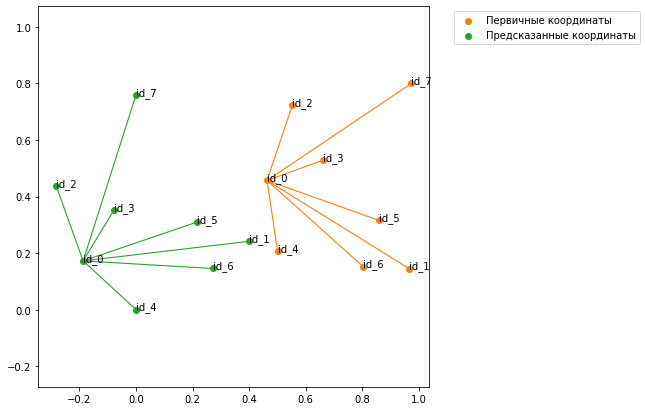

In [233]:
points=8
data=generate_points(points)
data =calculate_coordinates(data)
points_plot(data)
data

Тут есть два ключевых момента, на которые стоит обратить внимание:
        1. Выбор первых двух базовых точек
        2. Выбор третьей базовой точки

## Выбор первых двух базовых точек

Тут проблема кроется в следующем: модель обучена генерировать треугольники только в первом координатном секторе, если же реальная точка оказывается ниже, то она просто генерирует ее на оси X, где x=0, как показано на рисунке ниже.

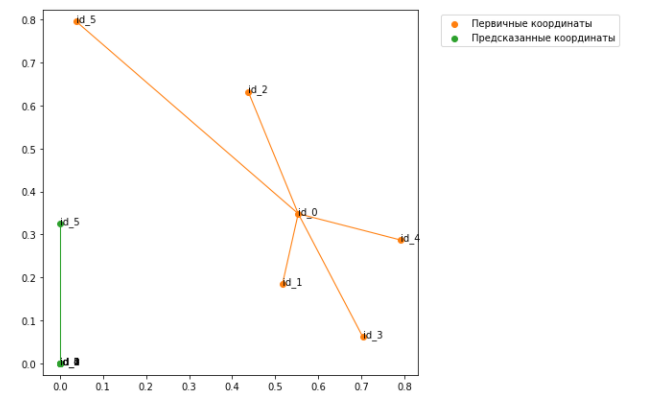

In [228]:
im=Image.open('pic5.PNG')
display(im)

Здесь за базовые взяты принудительно точки 2 и 5. Все остальные точки находящиеся относительно ниже, не отобразились.

Если же взять за базовые точки 3 и 5, то все будет нормально:

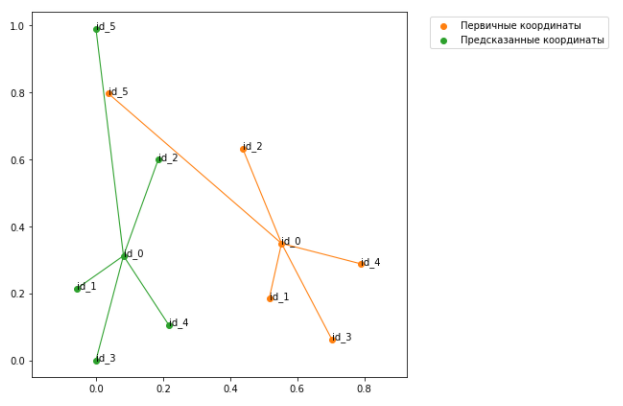

In [229]:
im=Image.open('pic6.PNG')
display(im)

Таким образом, чтобы избежать этой ошибки за базовые нужно брать точки расстояние между которыми в системе максимально. Что я и реализовал в программе.

## Выбор третьей базовой точки

С такой же логикой можно подойти и к выбору третьей базовой точки: это не обязательно, но если еее выбирать случайным образом, то она может расположиться оченбь близко к оси Y или вообще на этой оси, что приведет к ошибкам. По этому в программе я ее выбираю по максимальной сумме расстояний от первых двух базовых точек.

<a id='section_5'></a>
# Заключение

,X,Y,xhat,yhat
id_0,0.675688,0.762750,0.486812,0.439808
id_1,0.025732,0.677999,0.000000,0.000000
id_2,0.446321,0.317195,0.000000,0.554421
id_3,0.319089,0.179965,-0.188908,0.546496
id_4,0.786270,0.028683,0.000000,1.000601
id_5,0.806248,0.735732,0.551538,0.556797
id_6,0.977588,0.614492,0.570354,0.765331
id_7,0.131568,0.250201,-0.257259,0.358045
id_8,0.562461,0.500139,0.213948,0.523749
id_9,0.869859,0.151116,0.147284,0.985047


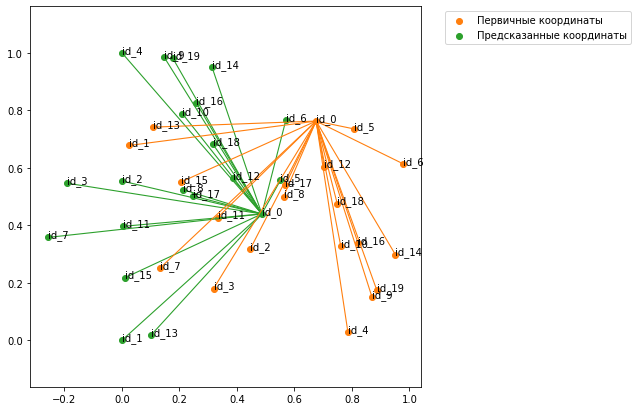

In [238]:
points=20
data=generate_points(points)
data =calculate_coordinates(data)
points_plot(data)
data

В целом на этом где-то можно и закончить: задача выполнена, модель определяет относительное расположение точек. Нюанс есть в том, что иногда это происходит в левонаправленной системе координат, но в условиях задачи об этом ничего не сказано. 

Можно конечно двигаться дальше и сделать линейное преобразование координат, но это уже другая, не связанная с этой проблема.

Обученную модель можно загрузить по ссылке: http://gofile.me/6ncNu/RfKgsf1Ty